In [1]:
# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
##from imblearn.over_sampling import SMOTE


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, roc_auc_score, roc_curve 
from sklearn.calibration import calibration_curve

## Load data

In [2]:
data = pd.read_excel('Inland_BEST2.xlsx',sheet_name='Sheet2')
data.head()

,ID_Code,MD_2015_Fish,MD_2015_Trips,Gender,Year_born,Race,Education,Household,Annual_Income,Employment,Age
0,100,0.0,NaN,1.0,NaN,1.0,1.0,16.0,NaN,9.0,NaN
1,1000,1.0,3.0,1.0,NaN,6.0,3.0,1.0,2.0,9.0,NaN
2,1047,1.0,5.0,1.0,1979.0,1.0,3.0,13.0,4.0,5.0,37.0
3,1059,1.0,2.0,1.0,1969.0,1.0,4.0,13.0,7.0,5.0,47.0
4,1068,1.0,5.0,1.0,1960.0,6.0,2.0,1.0,5.0,2.0,56.0


In [3]:
data.shape

(933, 11)

In [4]:
colnames = ['MD_2015_Fish', 'Gender', 'Age', 'Race', 'Education', 'Household', 'Annual_Income', 'Employment']

df_features = data[colnames].dropna()

df_features[['Race','Education','Household',
             'Annual_Income','Employment']] = df_features[['Race','Education',
                                                           'Household','Annual_Income','Employment']].astype(int) #change the float to integer in order to change to string

df_features[['Race','Education','Household',
             'Annual_Income','Employment']] = df_features[['Race','Education',
                                                           'Household','Annual_Income','Employment']].astype(str) #change the integer to string, so we can split each number, like 13 to "1" "3"
df_features.head()

,MD_2015_Fish,Gender,Age,Race,Education,Household,Annual_Income,Employment
2,1.0,1.0,37.0,1,3,13,4,5
3,1.0,1.0,47.0,1,4,13,7,5
4,1.0,1.0,56.0,6,2,1,5,2
5,1.0,1.0,55.0,4,5,14,6,2
7,1.0,2.0,43.0,1,4,34,1,6


## Data preprocessing

In [5]:
df1 = pd.DataFrame(columns=colnames)

for i in df_features.index:
    
    len_a = len(df_features.loc[i,'Household'])   
    len_b = len(df_features.loc[i,'Employment'])
    
    Label = df_features.loc[i,'MD_2015_Fish']
    Gender = df_features.loc[i,'Gender']
    Race = df_features.loc[i,'Race']
    Age = df_features.loc[i,'Age']
    Edu = df_features.loc[i,'Education']
    Income = df_features.loc[i,'Annual_Income']
    
    
    if len_a > 1:        
        for j in range(len_a):            
            if len_b > 1:
                for k in range(len_b):
                    House = df_features.loc[i,'Household'][j]
                    Emp = df_features.loc[i,'Employment'][k]

                    temp = pd.DataFrame([[Label, Gender, Age, Race, Edu, House, Income, Emp]], columns=colnames)
                    df1 = df1.append(temp)
                    
            else:
                House = df_features.loc[i,'Household'][j]
                Emp = df_features.loc[i,'Employment']
                temp = pd.DataFrame([[Label, Gender, Age, Race, Edu, House, Income, Emp]], columns=colnames)
                df1 = df1.append(temp)
                
    else:
        if len_b > 1:
            for k in range(len_b):
                House = df_features.loc[i,'Household']
                Emp = df_features.loc[i,'Employment'][k]

                temp = pd.DataFrame([[Label, Gender, Age, Race, Edu, House, Income, Emp]], columns=colnames)
                df1 = df1.append(temp)
                    
        else:
            House = df_features.loc[i,'Household']
            Emp = df_features.loc[i,'Employment']

            temp = pd.DataFrame([[Label, Gender, Age, Race, Edu, House, Income, Emp]], columns=colnames)
            df1 = df1.append(temp)
            
df1.reset_index(inplace=True, drop=True)
df1.Gender = df1.Gender - 1   #change Gender 1,2 to 0,1

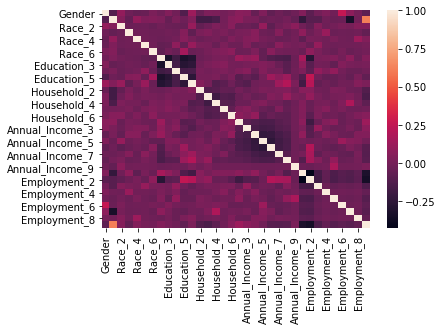

In [6]:
y = df1.MD_2015_Fish
X = pd.get_dummies(data=df1.iloc[:,1:], columns=['Race','Education','Household','Annual_Income','Employment'], drop_first=True)
sns.heatmap(X.corr())

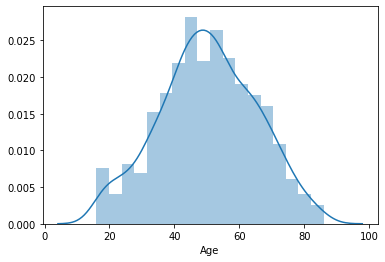

In [7]:
sns.distplot(X.Age)

## Build classification models

### 1) Logistic regression

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [9]:
# Train logistic regression
logit = LogisticRegression()
logit.fit(X_train, y_train)

y_pred = logit.predict(X_test)
y_pred_probs = logit.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         1.0       0.92      1.00      0.96       187

    accuracy                           0.92       203
   macro avg       0.46      0.50      0.48       203
weighted avg       0.85      0.92      0.88       203



In [10]:
# Set different random seeds to check testing accuracy

for seed in range(4):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, random_state = seed)
    # Train logistic regression
    logit = LogisticRegression()
    logit.fit(X_train, y_train)

    y_pred = logit.predict(X_test)
    y_pred_probs = logit.predict_proba(X_test)[:,1]
    print('=========================================================')
    print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        27
         1.0       0.92      1.00      0.96       328

    accuracy                           0.92       355
   macro avg       0.46      0.50      0.48       355
weighted avg       0.85      0.92      0.89       355

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        31
         1.0       0.91      1.00      0.95       324

    accuracy                           0.91       355
   macro avg       0.46      0.50      0.48       355
weighted avg       0.83      0.91      0.87       355

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        32
         1.0       0.91      1.00      0.95       323

    accuracy                           0.91       355
   macro avg       0.45      0.50      0.48       355
weighted avg       0.83      0.91      0.87       355

              preci

Text(0.5, 0, 'Threshold')

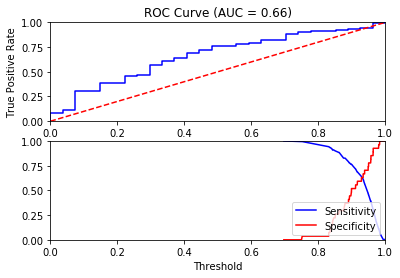

In [11]:
# ROC curve and threshold plot

plt.subplot(2, 1, 1)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1]); plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.subplot(2, 1, 2)

plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
plt.legend(loc = 'lower right')
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel('Threshold')

### Random forest

In [12]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_probs = rf.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.30      0.11      0.16        27
         1.0       0.93      0.98      0.95       328

    accuracy                           0.91       355
   macro avg       0.62      0.54      0.56       355
weighted avg       0.88      0.91      0.89       355



Text(0.5, 0, 'Threshold')

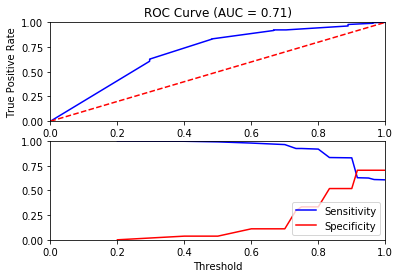

In [13]:
plt.subplot(2, 1, 1)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1]); plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.subplot(2, 1, 2)

plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
plt.legend(loc = 'lower right')
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel('Threshold')


[Text(0, 0, 'Annual_Income_6'),
 Text(0, 0, 'Employment_9'),
 Text(0, 0, 'Annual_Income_4'),
 Text(0, 0, 'Employment_3'),
 Text(0, 0, 'Household_4'),
 Text(0, 0, 'Age')]

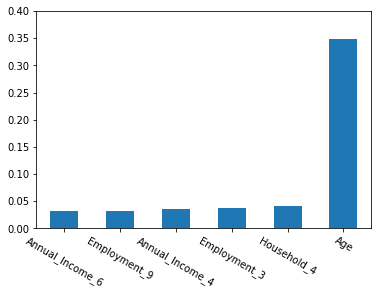

In [14]:
## Plot top 6 most significant features
top_idx = list(np.argsort(rf.feature_importances_)[-6:]) 
bplot = pd.Series(rf.feature_importances_[top_idx])
selected_features = pd.Series(X.columns)
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.4))
p2.set_xticklabels(xticks)